# Velocity reprojection
Point-to-point reprojection for velocity

In [1]:
import os
import numpy as np
from pyproj import Transformer, CRS
from shapely.geometry import Point
import rasterio
from rasterio.warp import Resampling, calculate_default_transform
from rasterio.transform import from_bounds
from rasterio.features import rasterize

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

from raster_basics.RasterBasics import shpClip, tifReprojectionResample, reproject_velocity, rasterLike


Load velocity data

In [2]:
# coordinate system and resolution
crs = 32606  # UTM zone 6N
res = 50 # output pixel resolution (m)


In [3]:
# locate velocity data
vx_fp_init = '/Users/albinwells/Desktop/GlacierMB/Other/ITS_LIVE_vx_2017_2018_composite.tif'
vy_fp_init = '/Users/albinwells/Desktop/GlacierMB/Other/ITS_LIVE_vy_2017_2018_composite.tif'

vx_fp_init_clip = 'vx_init_clip.tif' 
vy_fp_init_clip = 'vy_init_clip.tif'

# direct method of reprojection (save files)
vx_fp_dir = 'vx_reproj_orig.tif' 
vy_fp_dir = 'vy_reproj_orig.tif'
vv_fp_dir = 'vv_reproj_orig.tif'

# point-to-point reprojection (save files)
vx_fp_ptp = 'vx_reproj_ptp.tif' 
vy_fp_ptp = 'vy_reproj_ptp.tif'
vv_fp_ptp = 'vv_reproj_ptp.tif'


In [4]:
# check data CRS
crs_init = int(str(rasterio.open(vx_fp_init).crs).split(':')[1])
crs_init


3413

Straight velocity reprojection

In [5]:
# clip regional file
shp_fp = '/Users/albinwells/Desktop/GlacierMB/Other/Gulkana_USGS_2021.shp' # 2021 USGS outline
shpClip(vx_fp_init, shp_fp, vx_fp_init_clip, fill=False, pad_size=5)
shpClip(vy_fp_init, shp_fp, vy_fp_init_clip, fill=False, pad_size=5)


In [6]:
# reproject velocity
tifReprojectionResample(vx_fp_init_clip, vx_fp_dir, crs, res, Resampling.cubic_spline)
tifReprojectionResample(vy_fp_init_clip, vy_fp_dir, crs, res, Resampling.cubic_spline)

# clip off-glacier terrain
shpClip(vx_fp_dir, shp_fp, vx_fp_dir, pad_size=2)
shpClip(vy_fp_dir, shp_fp, vy_fp_dir, pad_size=2)

# save velocity magnitude 
vv_dir_arr = (rasterio.open(vx_fp_dir).read(1)**2 + rasterio.open(vy_fp_dir).read(1)**2)**0.5
rasterLike(vv_dir_arr, vv_fp_dir, vx_fp_dir)


Point-point reprojection

In [7]:
# def reproject_velocity(vx_fp, vy_fp, from_epsg, to_epsg, output_vx_fp, output_vy_fp, apply_correction=False, plot_changes=False, **kwargs):
#     '''
#     Reproject velocity:
#         1. Extract velocity data from geotiff
#         2. Convert geotiff to points: get start and end point of velocity vector
#         3. Reproject start and end points to new coordinate system
#         4. Rasterize reprojected points in new coordinate system
#         5. OPTIONAL: apply_correction: Adjust velocity vectors based on magnitude of a direct reprojection
#         6. OPTIONAL: plot_changes: Plot velocity vector reproject (contains optional arguments for plotting)

#     Arguments:
#         vx_fp, vy_fp: Input velocity vectors
#         from_epsg, to_epsg: Initial and target coordinate systems in EPSG number (e.g., 32606)
#         output_vx_fp, output_vy_fp: Output filepaths
#         apply_correction: whether to apply a correction that matches velocity magnitude with the direct reprojection (default: False)
#         plot_changes: show plot of reprojection (default: False)
#         **kwargs: Optional arguments passed along for plotting (quiv_scale, quiv_width, title, ctitle, base_arr_color, vmin, vcenter, vmax) 
#     '''
        
#     # ----------------  1. extract velocity data from existing geotiff ---------------- 
#     proj_from = CRS.from_user_input(from_epsg)
#     proj_to = CRS.from_user_input(to_epsg)
#     with rasterio.open(vx_fp) as vx_src, rasterio.open(vy_fp) as vy_src:
#         vx_data = vx_src.read(1)  # Read the vx component
#         vy_data = vy_src.read(1)  # Read the vy component
#         v_res = vx_src.res
#         transform_from = vx_src.transform  # Get the affine transform of the original raster
        
#     # ---------------- 2. convert geotiff values to points ---------------- 
#     rows, cols = np.indices(vx_data.shape)
#     lon, lat = rasterio.transform.xy(transform_from, rows, cols)
#     points_from = np.column_stack((np.array(lon).flatten(), np.array(lat).flatten()))

#     # calculate the velocity endpoints
#     vx_data[np.abs(vx_data) > 1e30] = 0 # remove NaN values
#     vy_data[np.abs(vy_data) > 1e30] = 0
#     vv_data = (vx_data**2 + vy_data**2)**0.5
#     endpoints_from = np.column_stack((points_from[:,0] + vx_data.flatten(), points_from[:,1] + vy_data.flatten()))

#     # ---------------- 3. reproject start and end points ---------------- 
#     transformer = Transformer.from_crs(proj_from, proj_to, always_xy=True)
#     points_to = np.array([transformer.transform(x, y) for x, y in points_from])
#     endpoints_to = np.array([transformer.transform(x, y) for x, y in endpoints_from])

#     # recalculate the velocity magnitude and components
#     dx = endpoints_to[:,0] - points_to[:,0]  # reprojected vx
#     dy = endpoints_to[:,1] - points_to[:,1]  # reprojected vy
#     angles = np.arctan2(dy, dx)
#     mask = ~((np.isnan(dx) | (dx == 0)) & (np.isnan(dy) | (dy == 0))) # mask off-glacier
    
#     # ---------------- 4. rasterize points ----------------     
#     transform_to, width, height = calculate_default_transform(proj_from, proj_to, vx_data.shape[1], vx_data.shape[0],
#                                                               *rasterio.open(vx_fp).bounds, resolution=rasterio.open(vx_fp).res[0])

#     pixel_size_x, pixel_size_y = v_res[0], v_res[1]
#     x_min, x_max = min(points_to[:,0])-(pixel_size_x/2), max(points_to[:,0])+(pixel_size_x/2)
#     y_min, y_max = min(points_to[:,1])-(pixel_size_y/2), max(points_to[:,1])+(pixel_size_y/2)
    
#     # raster dimensions
#     width = int((x_max - x_min) / pixel_size_x) + 1
#     height = int((y_max - y_min) / pixel_size_y) + 1

#     # define affine transform
#     transform = from_bounds(x_min, y_min, x_max, y_max, width, height)

#     # prepare the data for rasterization
#     points_vx = [(Point(coord), value) for coord, value in zip(zip(points_to[:,0][mask], points_to[:,1][mask]), dx[mask])]
#     points_vy = [(Point(coord), value) for coord, value in zip(zip(points_to[:,0][mask], points_to[:,1][mask]), dy[mask])]

#     # rasterize the data
#     vx_arr = rasterize(points_vx, out_shape=(height, width), transform=transform, dtype='float32')
#     vy_arr = rasterize(points_vy, out_shape=(height, width), transform=transform, dtype='float32')
#     vv_arr = np.sqrt(vx_arr**2 + vy_arr**2)

#     with rasterio.open(output_vx_fp, 'w', driver='GTiff', height=height, width=width, count=1, dtype='float32', 
#                        crs=proj_to, transform=transform) as dst:
#         dst.write(vx_arr, 1)
#     with rasterio.open(output_vy_fp, 'w', driver='GTiff', height=height, width=width, count=1, dtype='float32', 
#                        crs=proj_to, transform=transform) as dst:
#         dst.write(vy_arr, 1)

#     # ------------------- plotting ----------------------
#     if plot_changes:
#         quiv_scale = kwargs.get('quiv_scale', 200)
#         quiv_width = kwargs.get('quiv_width', 0.005)
#         quiv_color= kwargs.get('quiv_color', 'autumn')
    
#         title = kwargs.get('title', None)
#         ctitle = kwargs.get('ctitle', None)
#         base_arr_color = kwargs.get('base_arr_color', 'BrBG')
#         base_arr_vmin = kwargs.get('base_arr_vmin', 0)
#         base_arr_vcenter = kwargs.get('base_arr_vcenter', 10)
#         base_arr_vmax = kwargs.get('base_arr_vmax', 50)
    
#         # original plot
#         rasterLike(vv_data, 'tmp_vv_plt.tif', vx_fp)
#         quiv_plot(points_from[:,0], points_from[:,1], vx_data, vy_data, 1, quiv_scale, quiv_width=quiv_width, quiv_color=quiv_color,
#                   base_tiff='tmp_vv_plt.tif', title=title, ctitle=ctitle, base_arr_color=base_arr_color,  
#                   base_arr_vmin=base_arr_vmin, base_arr_vcenter=base_arr_vcenter, base_arr_vmax=base_arr_vmax)

#         # reprojected plot
#         rasterLike(vv_arr, 'tmp_vv_plt.tif', output_vx_fp)
#         quiv_plot(points_to[:,0][mask], points_to[:,1][mask], dx[mask], dy[mask], 1, quiv_scale, quiv_width=quiv_width, 
#                   quiv_color=quiv_color, base_tiff='tmp_vv_plt.tif', title=title, ctitle=ctitle, base_arr_color=base_arr_color,  
#                   base_arr_vmin=base_arr_vmin, base_arr_vcenter=base_arr_vcenter, base_arr_vmax=base_arr_vmax)

#     # ---------------- 5. apply correction based on straight reprojection magnitude ----------------
#     if apply_correction:
#         assert np.abs(pixel_size_x-pixel_size_y) < 0.1, f'Pixels are not square: ({pixel_size_x:.2f}, {pixel_size_y:.2f})'
#         # straight reprojection of velocity data
#         tifReprojectionResample(vx_fp, 'temp_vx.tif', proj_to, pixel_size_x, Resampling.cubic_spline) # reproject
#         tifReprojectionResample(vy_fp, 'temp_vy.tif', proj_to, pixel_size_x, Resampling.cubic_spline)
#         vx_arr_tmp = rasterio.open('temp_vx.tif').read(1)
#         vy_arr_tmp = rasterio.open('temp_vy.tif').read(1)
#         vx_arr_tmp[(np.abs(vx_arr_tmp) >= 1e10) | np.isnan(vx_arr_tmp)] = 0
#         vy_arr_tmp[(np.abs(vy_arr_tmp) >= 1e10) | np.isnan(vy_arr_tmp)] = 0
#         vv_dir_arr = (vx_arr_tmp**2 + vy_arr_tmp**2)**0.5 # derive velocity magnitude 

#         # adjust point-to-point velocity based on magnitude
#         mask_mag = (vv_dir_arr != 0) & (vv_arr != 0)
#         vx_arr_corr = np.copy(vx_arr)
#         vy_arr_corr = np.copy(vx_arr)
#         vx_arr_corr[mask_mag] = vx_arr[mask_mag] * vv_dir_arr[mask_mag] / vv_arr[mask_mag]
#         vy_arr_corr[mask_mag] = vy_arr[mask_mag] * vv_dir_arr[mask_mag] / vv_arr[mask_mag]
#         rasterLike(vx_arr_corr, output_vx_fp, 'temp_vx.tif')
#         rasterLike(vy_arr_corr, output_vy_fp, 'temp_vy.tif')
#         os.remove('temp_vx.tif')
#         os.remove('temp_vy.tif')
        
#     # ------------------- plotting ----------------------
#     if plot_changes:
#         # reprojected plot, with correction
#         if apply_correction:
#             vv_arr_corr = np.sqrt(vx_arr_corr**2 + vy_arr_corr**2)
#             rasterLike(vv_arr_corr, 'tmp_vv_plt.tif', output_vx_fp)
#             quiv_plot(points_to[:,0][mask], points_to[:,1][mask], dx[mask], dy[mask], 1, quiv_scale, quiv_width=quiv_width, 
#                       quiv_color=quiv_color, base_tiff='tmp_vv_plt.tif', title=title, ctitle=ctitle, base_arr_color=base_arr_color,
#                       base_arr_vmin=base_arr_vmin, base_arr_vcenter=base_arr_vcenter, base_arr_vmax=base_arr_vmax)
        
#         os.remove('tmp_vv_plt.tif')




# def quiv_plot(q1, q2, q3, q4, q5, q6, base_tiff=None, **kwargs):
#     """
#     Plots a velocity field with arrows and an optional background array.
    
#     Parameters:
#         q1, q2, q3, q4: Coordinates and components for quiver plot.
#         q5: Magnitude of arrows for quiver.
#         q6: Scale factor for quiver arrows.
#         base_tiff: Geotiff for the background plot (optional).
#         **kwargs: Additional parameters for base array customization:
#             - `quiv_width`: Quiver arrow width
#             - `quiv_color`: Quiver arrow color
#             - `title`: Plot title
#             - `ctitle`: Colorbar title
#             - `base_arr_color`: Colormap for the base array (default is 'RdBu').
#             - `base_arr_ext`: Extent of the base array (default is None).
#             - `base_arr_vmin`, `base_arr_vcenter`, `base_arr_vmax`: Min, center, and max for colorbar (default is -50, 0, 50)
#     """    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)  
    
#     quiv_width = kwargs.get('quiv_width', 0.005)
#     quiv_color= kwargs.get('quiv_color', 'autumn')
#     ax.quiver(q1, q2, q3, q4, q5, cmap=quiv_color, scale=q6, width=quiv_width)

#     title = kwargs.get('title', None)
#     ctitle = kwargs.get('ctitle', None)
#     base_arr_color = kwargs.get('base_arr_color', 'RdBu')
#     base_arr_vmin = kwargs.get('base_arr_vmin', 0)
#     base_arr_vcenter = kwargs.get('base_arr_vcenter', 10)
#     base_arr_vmax = kwargs.get('base_arr_vmax', 50)
#     if base_tiff is not None:
#         divnorm = TwoSlopeNorm(vmin=base_arr_vmin, vcenter=base_arr_vcenter, vmax=base_arr_vmax)
#         base_ext = [rasterio.open(base_tiff).bounds[0], rasterio.open(base_tiff).bounds[2], 
#                     rasterio.open(base_tiff).bounds[1], rasterio.open(base_tiff).bounds[3]]
#         im = ax.imshow(rasterio.open(base_tiff).read(1), cmap=mpl.colormaps[base_arr_color], norm=divnorm, extent=base_ext)
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size='5%', pad=0.05)
#         fig.colorbar(im, cax=cax, label=ctitle)
    
#     ax.set_title(title, weight='bold', pad=10)
#     fig.tight_layout(pad=3, w_pad=-3.0, h_pad=2.0)
#     plt.show()


In [8]:
crs_init, crs

(3413, 32606)

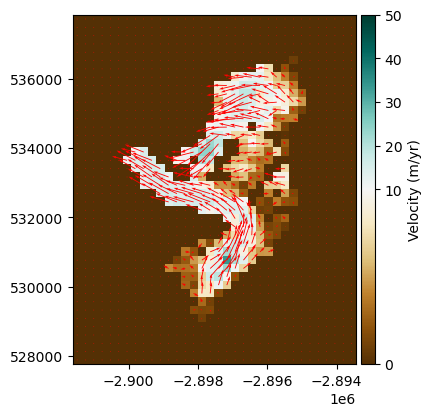

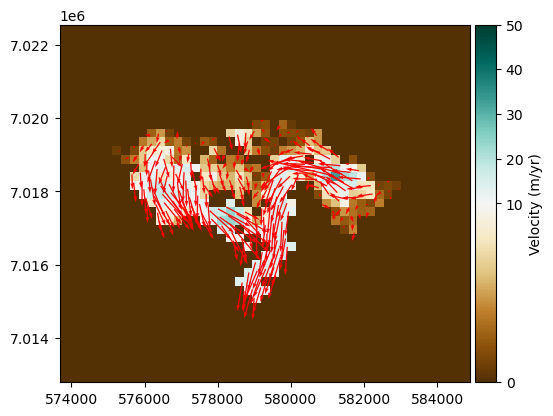

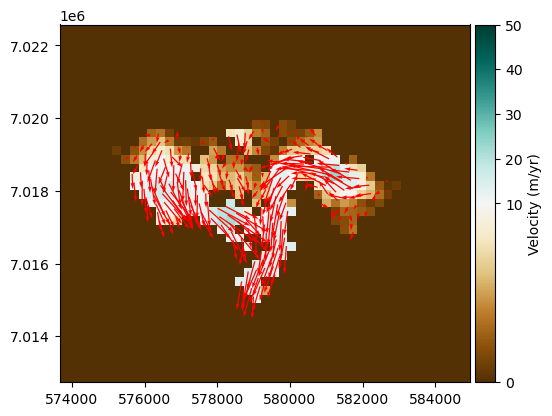

In [9]:
# # point-to-point velocity reprojection
# reproject_velocity(vx_fp=vx_fp_init_clip, vy_fp=vy_fp_init_clip, epsg_from=crs_init, epsg_to=crs,
#                    output_vx_fp=vx_fp_ptp, output_vy_fp=vy_fp_ptp, apply_correction=False, plot_changes=False)

# alternatively, we can use the correction
reproject_velocity(vx_fp=vx_fp_init_clip, vy_fp=vy_fp_init_clip, from_epsg=crs_init, to_epsg=crs,
                   output_vx_fp=vx_fp_ptp, output_vy_fp=vy_fp_ptp, apply_correction=True, plot_changes=True,
                   quiv_scale=200, quiv_width=0.003, ctitle='Velocity (m/yr)', vmin=0)


In [10]:
tifReprojectionResample(vx_fp_ptp, vx_fp_ptp, crs, res, Resampling.cubic_spline)
tifReprojectionResample(vy_fp_ptp, vy_fp_ptp, crs, res, Resampling.cubic_spline)


In [11]:
# clip off-glacier terrain
shpClip(vx_fp_ptp, shp_fp, vx_fp_ptp, pad_size=2)
shpClip(vy_fp_ptp, shp_fp, vy_fp_ptp, pad_size=2)

# save velocity magnitude 
vv_ptp_arr = (rasterio.open(vx_fp_ptp).read(1)**2 + rasterio.open(vy_fp_ptp).read(1)**2)**0.5
rasterLike(vv_ptp_arr, vv_fp_ptp, vx_fp_ptp)


### Compare velocity reprojection

In [12]:
def quiv(vx, vy, v_tot, pixel_size, threshold):
    freq = pixel_size
    xx = np.arange(0, vx.shape[1], freq)                          # last number represents arrow frequency
    yy = np.arange(0, vy.shape[0], freq)
    points = np.ix_(yy, xx)
    px, py = np.meshgrid(xx, yy)
    
    vx_norm = np.divide(vx[points], v_tot[points], out=np.zeros_like(vx[points]), where=v_tot[points] > threshold)
    vy_norm = np.divide(vy[points], v_tot[points], out=np.zeros_like(vx[points]), where=v_tot[points] > threshold)
    vx_norm[np.isnan(vx_norm)] = 0
    vy_norm[np.isnan(vy_norm)] = 0
    
    mask = np.logical_or(vx_norm != 0, vy_norm != 0)                # remove 0 points
    quiverInput = [px[mask], py[mask], vx_norm[mask], vy_norm[mask], 1, 'gist_gray', 20]
    return quiverInput


In [13]:
# get the quiver velocity arrow inputs
quiver_dir = quiv(-rasterio.open(vy_fp_dir).read(1), rasterio.open(vx_fp_dir).read(1), rasterio.open(vv_fp_dir).read(1), 10, threshold=1e-6)
quiver_ptp = quiv(rasterio.open(vx_fp_ptp).read(1), rasterio.open(vy_fp_ptp).read(1), rasterio.open(vv_fp_ptp).read(1), 10, threshold=1e-6)


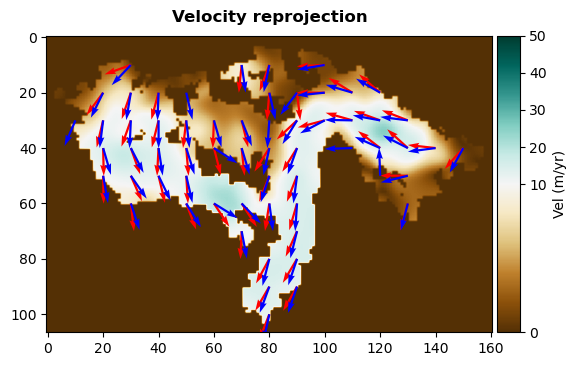

DIR direction in RED, PTP direction in BLUE


In [14]:
q_color_dir = 'autumn' # arrow color 1
q_color_ptp = 'winter' # arrow color 2
color = 'BrBG' # plot color

fig = plt.figure()
ax = fig.add_subplot(111, label="1")

divnorm = TwoSlopeNorm(vmin=0, vcenter=10, vmax=50)
im = ax.imshow(rasterio.open(vv_fp_dir).read(1), cmap=color, norm=divnorm)
# im = ax.imshow(rasterio.open(vv_fp_ptp).read(1), cmap=color, norm=divnorm)

ax.quiver(quiver_dir[0], quiver_dir[1], quiver_dir[2], quiver_dir[3], quiver_dir[4], cmap=q_color_dir, 
          scale=quiver_dir[6]*0.8, width=.005)
ax.quiver(quiver_ptp[0], quiver_ptp[1], quiver_ptp[2], quiver_ptp[3], quiver_ptp[4], cmap=q_color_ptp, 
          scale=quiver_ptp[6]*0.8, width=.005)
divider = make_axes_locatable(ax)

cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, label='Vel (m/yr)')
ax.set_title('Velocity reprojection', weight='bold', pad=10)
fig.tight_layout(pad=3, w_pad=-3.0, h_pad=2.0)
plt.show()
print('DIR direction in RED, PTP direction in BLUE')
    

Cleanup

In [15]:
os.remove(vx_fp_dir)
os.remove(vy_fp_dir)
os.remove(vv_fp_dir)
os.remove(vx_fp_ptp)
os.remove(vy_fp_ptp)
os.remove(vv_fp_ptp)
os.remove(vx_fp_init_clip)
os.remove(vy_fp_init_clip)
